# A more complex compositional model
This example sets up a more complex compositional simulation with five
different components. Other than that, the example is similar to the others
that include wells and is therefore not commented in great detail.

In [1]:
using MultiComponentFlash

n2_ch4 = MolecularProperty(0.0161594, 4.58e6, 189.515, 9.9701e-05, 0.00854)
co2 = MolecularProperty(0.04401, 7.3866e6, 304.200, 9.2634e-05, 0.228)
c2_5 = MolecularProperty(0.0455725, 4.0955e6, 387.607, 2.1708e-04, 0.16733)
c6_13 = MolecularProperty(0.117740, 3.345e6, 597.497, 3.8116e-04, 0.38609)
c14_24 = MolecularProperty(0.248827, 1.768e6, 698.515, 7.2141e-04, 0.80784)

bic = [0.11883 0.00070981 0.00077754 0.01 0.011;
       0.00070981 0.15 0.15 0.15 0.15;
       0.00077754 0.15 0 0 0;
       0.01 0.15 0 0 0;
       0.011 0.15 0 0 0]

mixture = MultiComponentMixture([n2_ch4, co2, c2_5, c6_13, c14_24], A_ij = bic, names = ["N2-CH4", "CO2", "C2-5", "C6-13", "C14-24"])
eos = GenericCubicEOS(mixture, PengRobinson())

using Jutul, JutulDarcy, GLMakie
Darcy, bar, kg, meter, Kelvin, day = si_units(:darcy, :bar, :kilogram, :meter, :Kelvin, :day)
nx = ny = 20
nz = 2

dims = (nx, ny, nz)
g = CartesianMesh(dims, (1000.0, 1000.0, 1.0))
nc = number_of_cells(g)
K = repeat([0.05*Darcy], 1, nc)
res = reservoir_domain(g, porosity = 0.25, permeability = K)

DataDomain wrapping CartesianMesh (3D) with 20x20x2=800 cells with 17 data fields added:
  800 Cells
    :permeability => 1×800 Matrix{Float64}
    :porosity => 800 Vector{Float64}
    :rock_thermal_conductivity => 800 Vector{Float64}
    :fluid_thermal_conductivity => 800 Vector{Float64}
    :rock_density => 800 Vector{Float64}
    :cell_centroids => 3×800 Matrix{Float64}
    :volumes => 800 Vector{Float64}
  1920 Faces
    :neighbors => 2×1920 Matrix{Int64}
    :areas => 1920 Vector{Float64}
    :normals => 3×1920 Matrix{Float64}
    :face_centroids => 3×1920 Matrix{Float64}
  3840 HalfFaces
    :half_face_cells => 3840 Vector{Int64}
    :half_face_faces => 3840 Vector{Int64}
  960 BoundaryFaces
    :boundary_areas => 960 Vector{Float64}
    :boundary_centroids => 3×960 Matrix{Float64}
    :boundary_normals => 3×960 Matrix{Float64}
    :boundary_neighbors => 960 Vector{Int64}


Set up a vertical well in the first corner, perforated in all layers

In [2]:
prod = setup_vertical_well(g, K, nx, ny, name = :Producer)

MultiSegmentWell [Producer] (3 nodes, 2 segments, 2 perforations)

Set up an injector in the opposite corner, perforated in all layers

In [3]:
inj = setup_vertical_well(g, K, 1, 1, name = :Injector)

rhoLS = 1000.0*kg/meter^3
rhoVS = 100.0*kg/meter^3

rhoS = [rhoLS, rhoVS]
L, V = LiquidPhase(), VaporPhase()

(LiquidPhase(), VaporPhase())

Define system and realize on grid

In [4]:
sys = MultiPhaseCompositionalSystemLV(eos, (L, V))
model, parameters = setup_reservoir_model(res, sys, wells = [inj, prod], reference_densities = rhoS, block_backend = true);
kr = BrooksCoreyRelativePermeabilities(sys, 2.0, 0.0, 1.0)
model = replace_variables!(model, RelativePermeabilities = kr)

push!(model[:Reservoir].output_variables, :Saturations)

parameters[:Reservoir][:Temperature] = 387.45*Kelvin
state0 = setup_reservoir_state(model, Pressure = 225*bar, OverallMoleFractions = [0.463, 0.01640, 0.20520, 0.19108, 0.12432]);

dt = repeat([2.0]*day, 365)
rate_target = TotalRateTarget(0.0015)
I_ctrl = InjectorControl(rate_target, [0, 1, 0, 0, 0], density = rhoVS)
bhp_target = BottomHolePressureTarget(100*bar)
P_ctrl = ProducerControl(bhp_target)

controls = Dict()
controls[:Injector] = I_ctrl
controls[:Producer] = P_ctrl
forces = setup_reservoir_forces(model, control = controls)
ws, states = simulate_reservoir(state0, model, dt, parameters = parameters, forces = forces)

Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps   1%  ETA: 0:58:06
  Progress:  Solving step 2/365 (0.55% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps   2%  ETA: 0:16:50
  Progress:  Solving step 7/365 (1.92% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps   5%  ETA: 0:06:55
  Progress:  Solving step 17/365 (4.66% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps   7%  ETA: 0:04:21
  Progress:  Solving step 27/365 (7.40% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps  10%  ETA: 0:03:16
  Progress:  Solving step 36/365 (9.86% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps  12%  ETA: 0:02:40
  Progress:  Solving step 44/365 (12.05% of time interval complete)


Simulating 1 year, 52 weeks, 18.18 hours as 365 report steps  14%  ETA: 0:02:15
  Progress:  Solving step 5

ReservoirSimResult with 365 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :lrat => Vector{Float64} of size (365,)
       :orat => Vector{Float64} of size (365,)
       :control => Vector{Symbol} of size (365,)
       :bhp => Vector{Float64} of size (365,)
       :mass_rate => Vector{Float64} of size (365,)
       :rate => Vector{Float64} of size (365,)
       :grat => Vector{Float64} of size (365,)

  states (Vector with 365 entries, reservoir variables for each state)
    :LiquidMassFractions => Matrix{Float64} of size (5, 800)
    :OverallMoleFractions => Matrix{Float64} of size (5, 800)
    :Saturations => Matrix{Float64} of size (2, 800)
    :Pressure => Vector{Float64} of size (800,)
    :VaporMassFractions => Matrix{Float64} of size (5, 800)
    :TotalMasses => Matrix{Float64} of size (5, 800)

  time (report time for each state)
     Vector{Float64} of length 365

  result (extended states, reports)
     SimResult with 365 entries

  ext

## Once the simulation is done, we can plot the states
### CO2 mole fraction

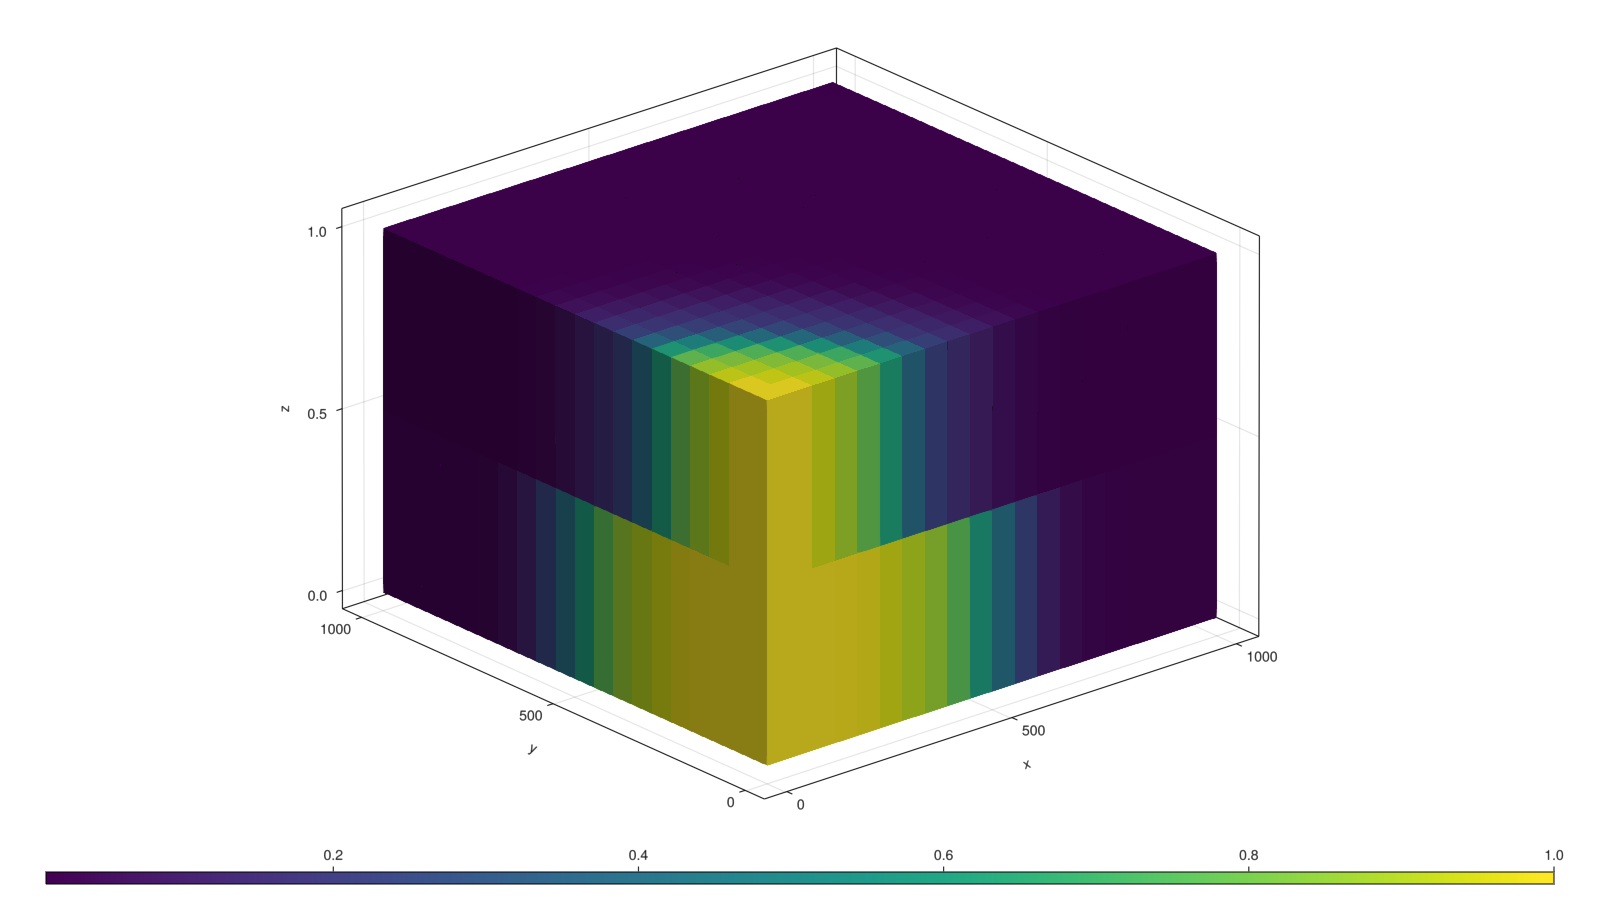

In [5]:
sg = states[end][:OverallMoleFractions][2, :]
fig, ax, p = plot_cell_data(g, sg)
fig

### Gas saturation

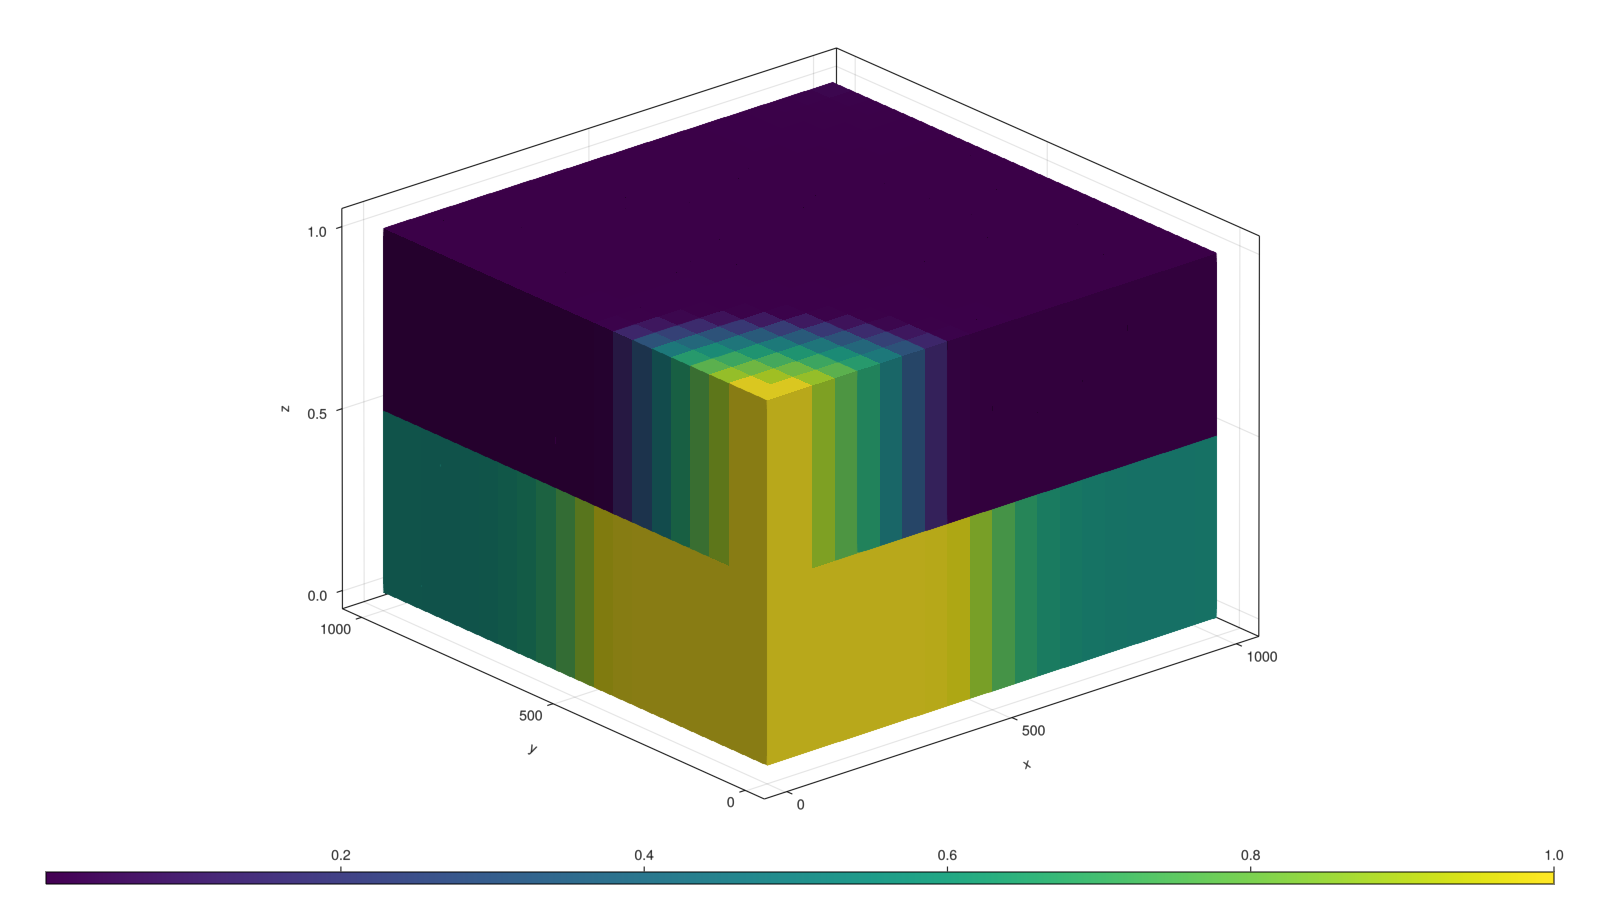

In [6]:
sg = states[end][:Saturations][2, :]
fig, ax, p = plot_cell_data(g, sg)
fig

### Pressure

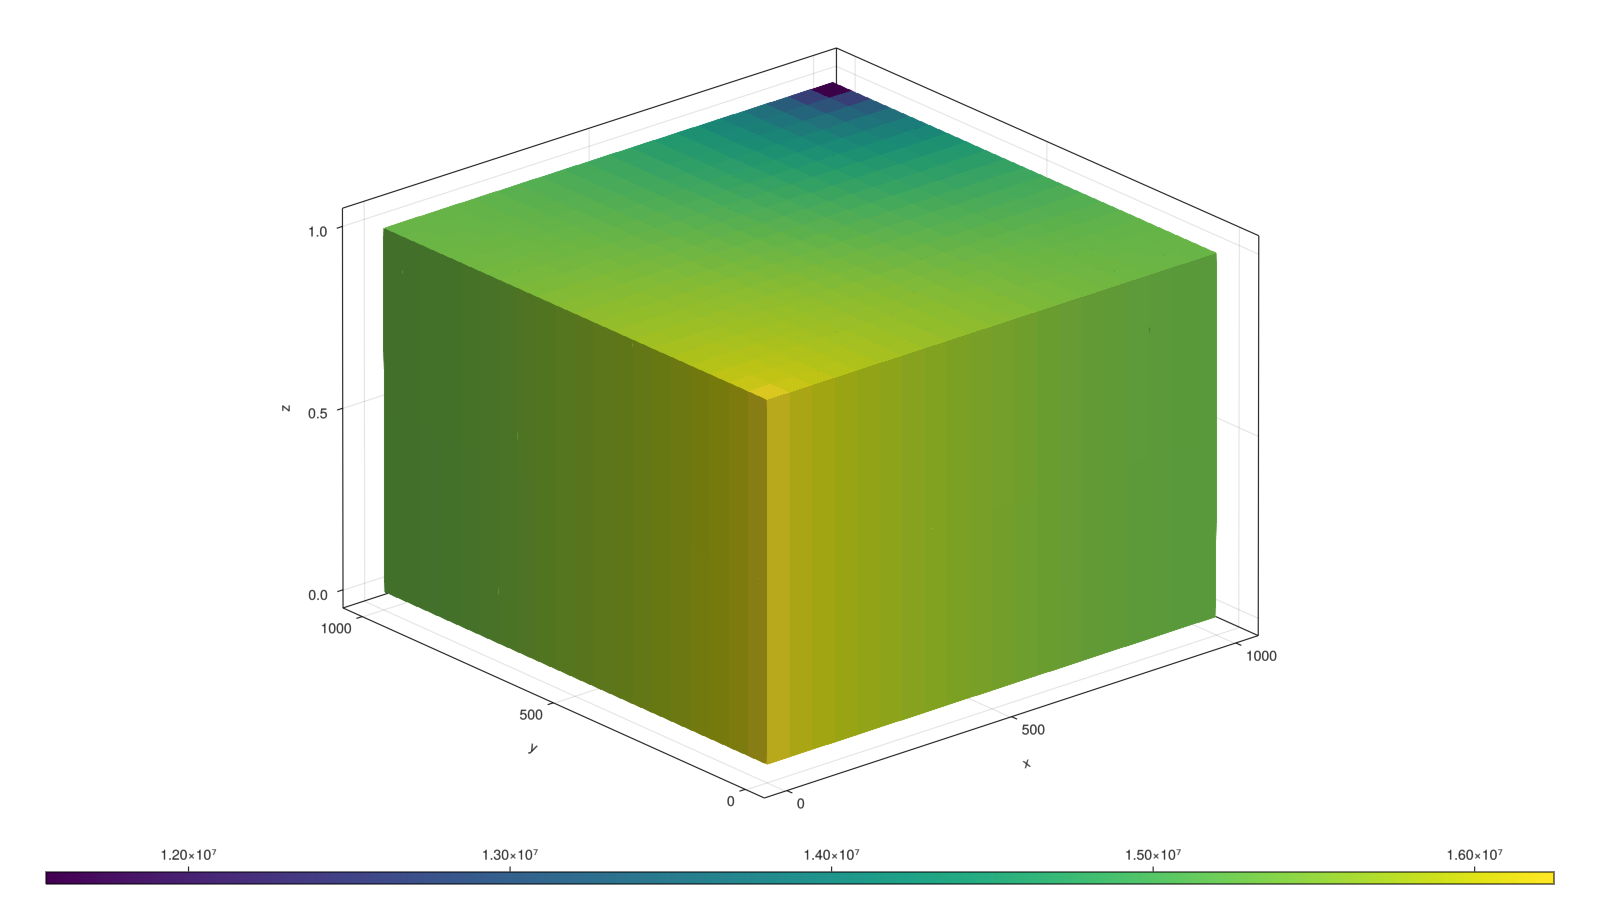

In [7]:
p = states[end][:Pressure]
fig, ax, p = plot_cell_data(g, p)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*